In [33]:
# Import Library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [34]:
# Load data
data = pd.read_csv("metrics-with-output.csv")
data

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [35]:
# Menampilkan baris pertama data
print(data.head())

                  Time      Timestamp cpu_usage memory_usage  \
0  2023-09-08 01:16:00  1694110560000     9.00%        53.5%   
1  2023-09-08 01:16:05  1694110565000     16.6%        53.3%   
2  2023-09-08 01:16:10  1694110570000     20.2%        55.3%   
3  2023-09-08 01:16:15  1694110575000     14.6%        58.0%   
4  2023-09-08 01:16:20  1694110580000     10.2%        53.5%   

  bandwidth_inbound bandwidth_outbound         tps tps_error response_time  \
0         7.46 GB/s          6.45 GB/s     2 req/s   0 req/s        607 ms   
1         5.85 GB/s          5.27 GB/s  2.20 req/s   0 req/s        2.09 s   
2         9.06 GB/s          7.96 GB/s  3.20 req/s   0 req/s        3.45 s   
3         8.41 GB/s          7.21 GB/s  3.20 req/s   0 req/s        2.58 s   
4         4.88 GB/s          4.30 GB/s  2.60 req/s   0 req/s        862 ms   

   Status  
0       0  
1       0  
2       0  
3       0  
4       0  


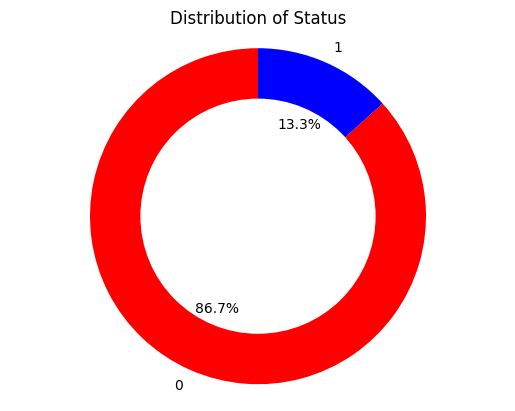

In [36]:
import matplotlib.pyplot as plt

#Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = data['Status'].value_counts()

colors = ['red','blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()

In [37]:
# Preprocessing

# Konversi Dataset
data['cpu_usage'] = data['cpu_usage'].str.rstrip('%').astype('float') / 100.0
data['memory_usage'] = data['memory_usage'].str.rstrip('%').astype('float') / 100.0

In [38]:
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

In [39]:
data['bandwidth_inbound'] = data['bandwidth_inbound'].apply(clean_bandwidth)
data['bandwidth_outbound'] = data['bandwidth_outbound'].apply(clean_bandwidth)
data['tps'] = data['tps'].str.rstrip(' req/s').astype('float')
data['tps_error'] = data['tps_error'].str.rstrip(' req/s').astype('float')
data['response_time'] = data['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [40]:
# Menampilkan data setelah konversi
data.info()
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB
                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110

In [41]:
data = data.drop(data.columns[[0,1]], axis=1)
data.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [42]:
# Preprocessing Data
from sklearn.preprocessing import LabelEncoder

#Mendefinisikan fitur dan label
features = data.drop(columns='Status')
labels = data['Status']

#Standarisasi fitur
# Encode 'Status' column into numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
scaler = StandardScaler()
features = scaler.fit_transform(features)

#Memisahkan data ke dalam set training dan test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [43]:
# Periksa apakah ada data yang hilang
missing_data = data.isnull().sum()
if missing_data.any():
    print("Data terdapat missing values yang perlu diimputasi:")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset.")

Tidak ada missing values dalam dataset.


In [44]:
# Menginisialisasi CustomEnv
import gym as gym
from gym import spaces

class CustomEnv(gym.Env):
    def __init__(self, features, labels):
        super(CustomEnv, self).__init__()
        self.features = features
        self.labels = labels
        self.current_step = 0
        self.total_reward = 0
        self.episode_rewards = []

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # Assuming binary classification (healthy/unhealthy)

    def reset(self):
        self.current_step = 0
        self.total_reward = 0
        return self.features[self.current_step]

    def step(self, action):
        reward = 1 if action == self.labels[self.current_step] else -1
        self.total_reward += reward
        self.current_step += 1

        done = self.current_step >= len(self.features)
        if done:
            self.episode_rewards.append(self.total_reward)

        obs = self.features[self.current_step] if not done else np.zeros(self.features.shape[1])

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass


In [45]:
# Create environment
# env = DummyVecEnv([lambda: CustomEnv(X_train, y_train)])

env = DummyVecEnv([lambda: CustomEnv(X_train, y_train)])

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [46]:
# Training Model
# Instantiate the PPO model
model = PPO('MlpPolicy', env, verbose=1, )

# Train the model
model.learn(total_timesteps=1800)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3566 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------


In [47]:
# Mengevaluasi Model
def evaluate_model(model, X_test, y_test):
    predicted_statuses = []

    for obs in X_test:
        obs = np.array(obs).reshape(1, -1)
        action, _ = model.predict(obs)
        predicted_statuses.append(action[0])

    predicted_statuses = np.array(predicted_statuses)

    accuracy = np.mean(np.array(predicted_statuses) == y_test)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return predicted_statuses


In [48]:
# Evaluate the model
predicted_statuses = evaluate_model(model, X_test, y_test)

Accuracy: 59.25%


   Actual  Predicted
0       0          0
1       0          0
2       1          0
3       0          0
4       1          1


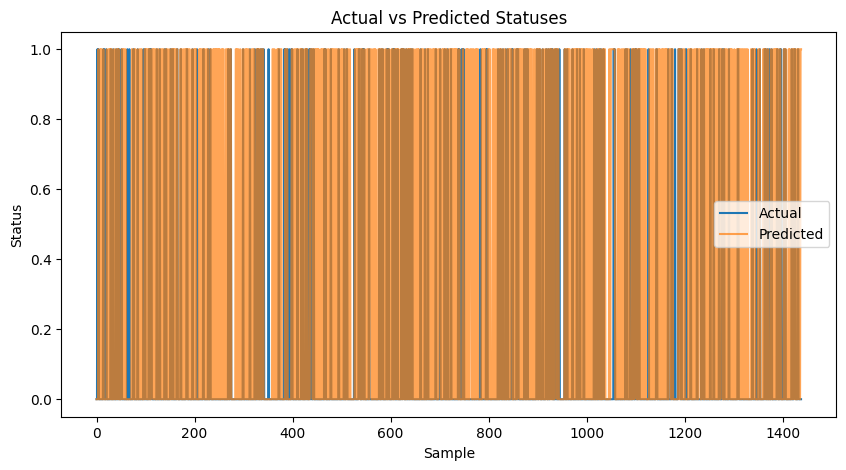

In [50]:
import matplotlib.pyplot as plt

# Plot actual vs predicted statuses
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_statuses})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Actual'].values, label='Actual')
plt.plot(comparison_df['Predicted'].values, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Status')
plt.title('Actual vs Predicted Statuses')
plt.show()

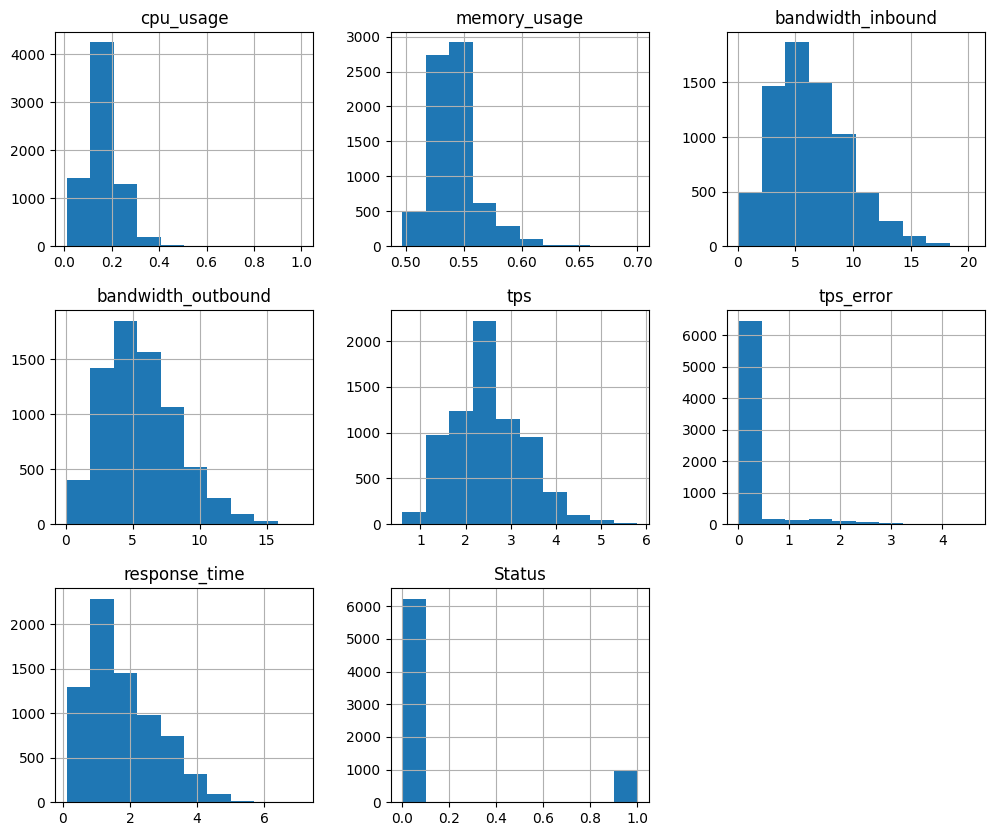

In [51]:
data.hist(figsize=(12, 10))
plt.show()

In [52]:
# Plot the episode rewards during training
model

In [53]:
y_test

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [54]:
len(predicted_statuses)

1438

Confusion Matrix - Validation Data
[[739 489]
 [ 97 113]]


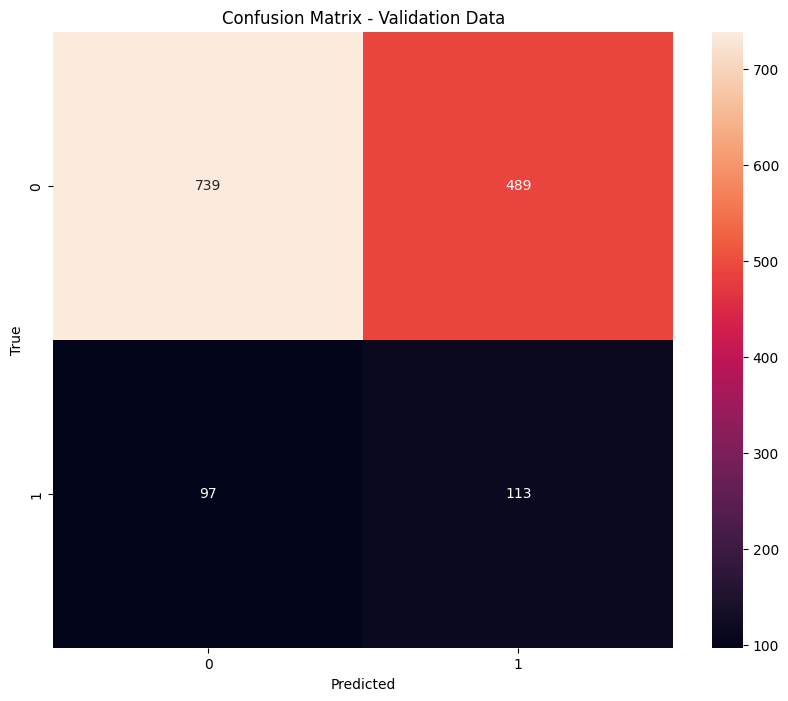

Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.88      0.60      0.72      1228
           1       0.19      0.54      0.28       210

    accuracy                           0.59      1438
   macro avg       0.54      0.57      0.50      1438
weighted avg       0.78      0.59      0.65      1438



In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Menghitung dan menampilkan confusion matrix untuk data validasi
cm_val = confusion_matrix(y_test, predicted_statuses)
print("Confusion Matrix - Validation Data")
print(cm_val)

# Menampilkan confusion matrix sebagai heatmap untuk data validasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Menghitung dan menampilkan classification report untuk data validasi
print("Classification Report - Validation Data")
report_val = classification_report(y_test, predicted_statuses)
print(report_val)

In [61]:
len(predicted_statuses)

1438